# Import libraries



In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.io as scio
import os
import pac
import mne
import pickle
import itertools
from numba import jit, cuda



## Necessary functions

In [2]:
# x axis ticks formater
def format_func(value, tick_number):
    # find number of multiples of pi/2
    if value == 0:
        return "(-200,0)"
    elif value == 1:
        return "(0,200)"
    elif value == 2:
        return "(200,400)"
    elif value == 3:
        return "(400,600)"
    elif value == 4:
        return "(600,800)"
    elif value == 5:
        return "(800,1000)" 

### Load and set some necessary data and parameters

In [18]:
with open('..\data\channels_name.pkl', 'rb') as f:
        channels_name = pickle.load(f)
event_types = ['Target','Standard','Novelty']
groups = ['PD_ON','PD_OFF','CTL'] 
Result_path = 'D:\Mastersharif\MasterProject\Working_with_kiani\\articles\Result_on_articles'       

In [4]:
list_tasks_info = pd.read_csv('../matlab/task_track_file.csv',usecols=['local_file_path','ERP_npy_file','ERP_nobaseline_npy_file','Group_file_type'])
num_task_file = list_tasks_info.shape[0]
print(num_task_file)
list_tasks_info
nobaseline = True

75


# Plot PAC for ERPs topography on head

### Using the ERPs signals calculated in matlab

## Load ERPs
### with baseline correction
### At first, Load Path lists



In [19]:
Path = 'D:\Mastersharif\MasterProject\data\parkinsons-oddball'
nobaseline = False
ERP_collection = np.zeros([3,25,3,63,601])
list_tasks_info.shape[0]
counter_PD_on = 0
counter_PD_off = 0
counter_CTL = 0
for i in np.arange(num_task_file):
    Path_to_save_file = os.path.join(Path,list_tasks_info['local_file_path'][i],list_tasks_info['ERP_npy_file'][i])
    ERP_array = np.load(Path_to_save_file)
    if list_tasks_info['Group_file_type'][i] == 'PD_ON':
        ERP_collection[0,counter_PD_on,:,:,:] = ERP_array
        counter_PD_on = counter_PD_on + 1
    elif list_tasks_info['Group_file_type'][i] == 'PD_OFF':
        ERP_collection[1,counter_PD_off,:,:,:] = ERP_array
        counter_PD_off = counter_PD_off + 1
    elif list_tasks_info['Group_file_type'][i] == 'CTL':
        ERP_collection[2,counter_CTL,:,:,:] = ERP_array
        counter_CTL = counter_CTL + 1

### without baseline correction

In [9]:
Path = 'D:\Mastersharif\MasterProject\data\parkinsons-oddball'

ERP_collection = np.zeros([3,25,3,63,601])
list_tasks_info.shape[0]
counter_PD_on = 0
counter_PD_off = 0
counter_CTL = 0
for i in np.arange(num_task_file):
    Path_to_save_file = os.path.join(Path,list_tasks_info['local_file_path'][i],list_tasks_info['ERP_nobaseline_npy_file'][i])
    ERP_array = np.load(Path_to_save_file)
    if list_tasks_info['Group_file_type'][i] == 'PD_ON':
        ERP_collection[0,counter_PD_on,:,:,:] = ERP_array
        counter_PD_on = counter_PD_on + 1
    elif list_tasks_info['Group_file_type'][i] == 'PD_OFF':
        ERP_collection[1,counter_PD_off,:,:,:] = ERP_array
        counter_PD_off = counter_PD_off + 1
    elif list_tasks_info['Group_file_type'][i] == 'CTL':
        ERP_collection[2,counter_CTL,:,:,:] = ERP_array
        counter_CTL = counter_CTL + 1

## Check Calculation with the result of Kiani

(3, 25, 3, 2, 63, 601)


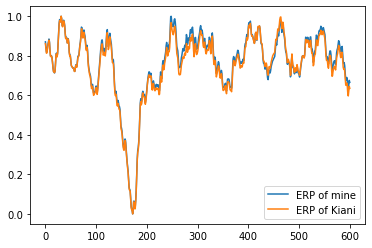

In [19]:
ERP = np.load('..\data\epochs.npz')
ERP = ERP['epochs']
print(ERP.shape)
Group_num = 1
Subject_num = 3
Stimulus_num = 1
Channel_num = 1


temp = ERP_collection[Group_num,Subject_num,Stimulus_num,Channel_num,:]
vmax = np.max(temp)
vmin = np.min(temp)
temp_norm = (temp-vmin)/(vmax-vmin)
plt.plot(temp_norm)

temp1 = ERP[0,Subject_num,Stimulus_num,0,Channel_num,:]
vmax = np.max(temp1)
vmin = np.min(temp1)
temp1_norm = (temp1-vmin)/(vmax-vmin)
plt.plot(temp1_norm)

plt.legend(['ERP of mine','ERP of Kiani'])

## Check calculation with matlab


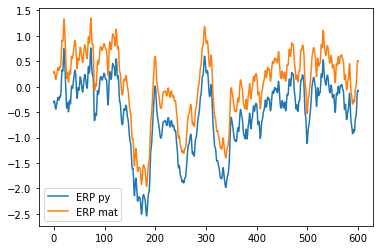

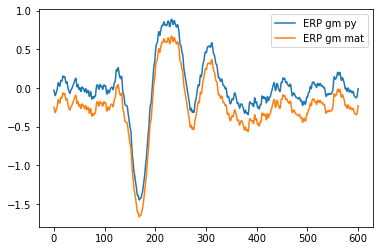

In [12]:
temp_dict = scio.loadmat('..\matlab\Test_ERP_collection.mat')
ERP_collection_matlab = temp_dict['ERP_collection']

Group_num = 1
Subject_num = 1
Stimulus_num = 1
Channel_num = 1

plt.plot(ERP_collection[Group_num,Subject_num,Stimulus_num,Channel_num,:])


ERP_test_matlab = ERP_collection_matlab[Group_num,Subject_num,Stimulus_num,Channel_num,:]

# Test with baseline
# average = np.mean(ERP_test_matlab[1:101])
# ERP_test_matlab = ERP_test_matlab - average

# Test without baseline
ERP_test_matlab = ERP_test_matlab
plt.plot(ERP_test_matlab)

plt.legend(['ERP py','ERP mat'])

plt.show


ERP_grand_mean_Py = np.mean(ERP_collection[Group_num,:,Stimulus_num,Channel_num,:],axis=0)

# Test ERP grandmean with basline
# average = np.mean(ERP_collection_matlab[Group_num,:,Stimulus_num,Channel_num,1:101],axis=1)

# average = np.expand_dims(average,axis=1)
# Temp_ERP_calculation = ERP_collection_matlab[Group_num,:,Stimulus_num,Channel_num,:]-average

# Test ERP grandmean without basline
Temp_ERP_calculation = ERP_collection_matlab[Group_num,:,Stimulus_num,Channel_num,:]
ERP_grand_mean_mat = np.mean(Temp_ERP_calculation,axis=0)

plt.figure()

plt.plot(ERP_grand_mean_Py)

plt.plot(ERP_grand_mean_mat)


plt.legend(['ERP gm py','ERP gm mat'])

plt.show()




## Plot ERP for some selected channels

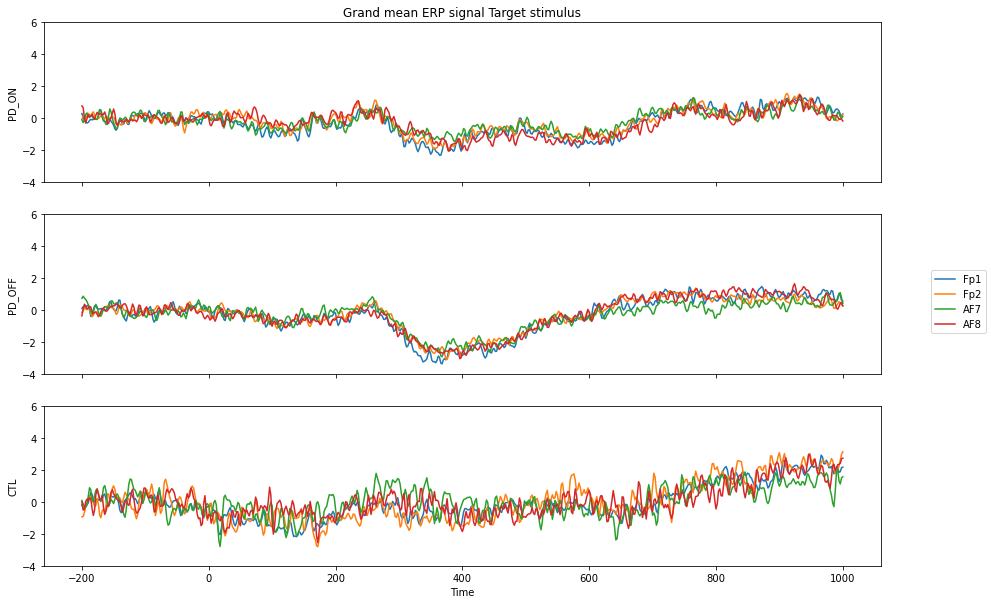

In [36]:
select_channels = {'AF7','AF8','Fp1','Fp2'}

colors = ['r','g','b','orange']

NUM_COLORS = 4

cm = plt.get_cmap('viridis')

num_sti = 0

fig, ax = plt.subplots(3,1,sharex=True,figsize=(15, 10))
times = np.linspace(-200,1000,601)
for i in np.arange(3):
    for c,ch_name in enumerate(select_channels):
        ch = channels_name.index(ch_name)
        ax[i].plot(times,np.mean(ERP_collection[i,:,num_sti,ch,:],axis=0))
        # baseline.set_linewidth(0)
        ax[i].set_ylabel(groups[i])
        ax[i].set_ylim([-4,6])   
# ax[2].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax[0].set_title(f'Grand mean ERP signal {event_types[num_sti]} stimulus')
ax[2].set_xlabel('Time')
fig.legend(select_channels,loc='center right')
plt.savefig(os.path.join(Result_path,f'selected_channels_erp_{event_types[num_sti]}.png'))

## PAC topography parameter


In [20]:
start_time = -200
end_time = 1000

nobaseline = False

start_sample = np.int32((start_time+200)/2)

end_sample = np.int32((end_time+200)/2)



  



# Pair of frequency
# maybe it needs to average on Pairs of frequency in the interested region
High_fre = 30
Low_fre = 6

# duration for PAC time series
# it might change to a greater value due to possibility of temporal loss information of low frequency activities
duration = 100

## PAC grand mean topography on head just for a pair of frequency 


In [21]:
PAC_on_electrodes = np.zeros([3,3,63]) # Group name, stimulus type, channel num



# function optimized to run on gpu 
@jit
def PAC_caluculation():
    for i in np.arange(3):
        for j in np.arange(3):
            # for ch in np.arange(63):
            #     ERP_grand_mean = np.mean(ERP_collection[i,:,j,ch,start_sample:end_sample+1],axis=0)
            #     PAC_on_electrodes[i,j,ch] = pac.tfMVL(ERP_grand_mean,high_freq=[High_fre,High_fre],low_freq=[Low_fre,Low_fre],Fs=500)
            for ch in np.arange(63):
                mean_temp = 0
                sub = 0
                # for sub in np.arange(25): 
                #     mean_temp = (sub*mean_temp + pac.tfMVL(ERP_collection[i,sub,j,ch,start_sample:end_sample+1],high_freq=[High_fre,High_fre],low_freq=[Low_fre,Low_fre],Fs=500))/(sub+1) 
                mean_temp = pac.tfMVL(ERP_collection[i,sub,j,ch,start_sample:end_sample+1],high_freq=[High_fre,High_fre],low_freq=[Low_fre,Low_fre],Fs=500) 
                PAC_on_electrodes[i,j,ch] = mean_temp

if __name__=="__main__":
    PAC_caluculation()
    # np.save(f'..\data\PAC_electordes_{start_time}_{end_time}_pair_fre_{High_fre}_{Low_fre}_nb_{nobaseline}',PAC_on_electrodes)



C:\Users\Mohammad\AppData\Local\Temp/ipykernel_13952/4127689939.py:6: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "PAC_caluculation" failed type inference due to: Unknown attribute 'tfMVL' of type Module(<module 'pac' from 'd:\\Mastersharif\\MasterProject\\Working_with_kiani\\git\\parkinson-pac\\python\\pac.py'>)

File "C:\Users\Mohammad\AppData\Local\Temp\ipykernel_13952\4127689939.py", line 18:
<source missing, REPL/exec in use?>

During: typing of get attribute at C:\Users\Mohammad\AppData\Local\Temp/ipykernel_13952/4127689939.py (18)

File "C:\Users\Mohammad\AppData\Local\Temp\ipykernel_13952\4127689939.py", line 18:
<source missing, REPL/exec in use?>

  @jit
C:\Users\Mohammad\AppData\Local\Temp/ipykernel_13952/4127689939.py:6: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "PAC_caluculation" failed type inference due to: Cannot determine Numba type of <class 'numba.core

In [7]:
f'..\data\PAC_electordes_{High_fre}_{Low_fre}_duration_{end_time-start_time}.npy'
f'..\data\PAC_electordes_{High_fre}_{Low_fre}_duration_{end_time-start_time}_nb_{nobaseline}.npy'

'..\\data\\PAC_electordes_30_6_duration_200_nb_False.npy'

## Save channel_names


In [9]:
channels = scio.loadmat('..\matlab\channel_name.mat')
channels = channels['channel_name']
channels = np.squeeze(channels)
channels_name = []
for i in np.arange(channels.shape[0]):
      channels_name.append(channels[i][0])

with open('..\data\channels_name.pkl', 'wb') as f:
     pickle.dump(channels_name, f)


## Check PAC with Kiani

(63,)
(3, 3, 63)


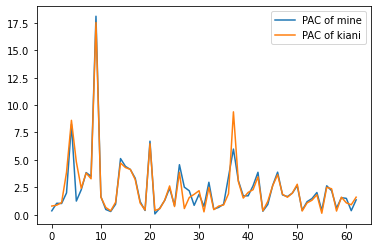

In [23]:


PAC = np.load('..\data\mvls30_6_sub1.npz')

PAC = PAC['S200']

PAC = PAC[:,:,10,2]

PAC = np.diag(PAC)
print(PAC.shape)
print(PAC_on_electrodes.shape)

plt.plot(PAC_on_electrodes[0,0,:])

plt.plot(PAC)

plt.legend(['PAC of mine','PAC of kiani'])










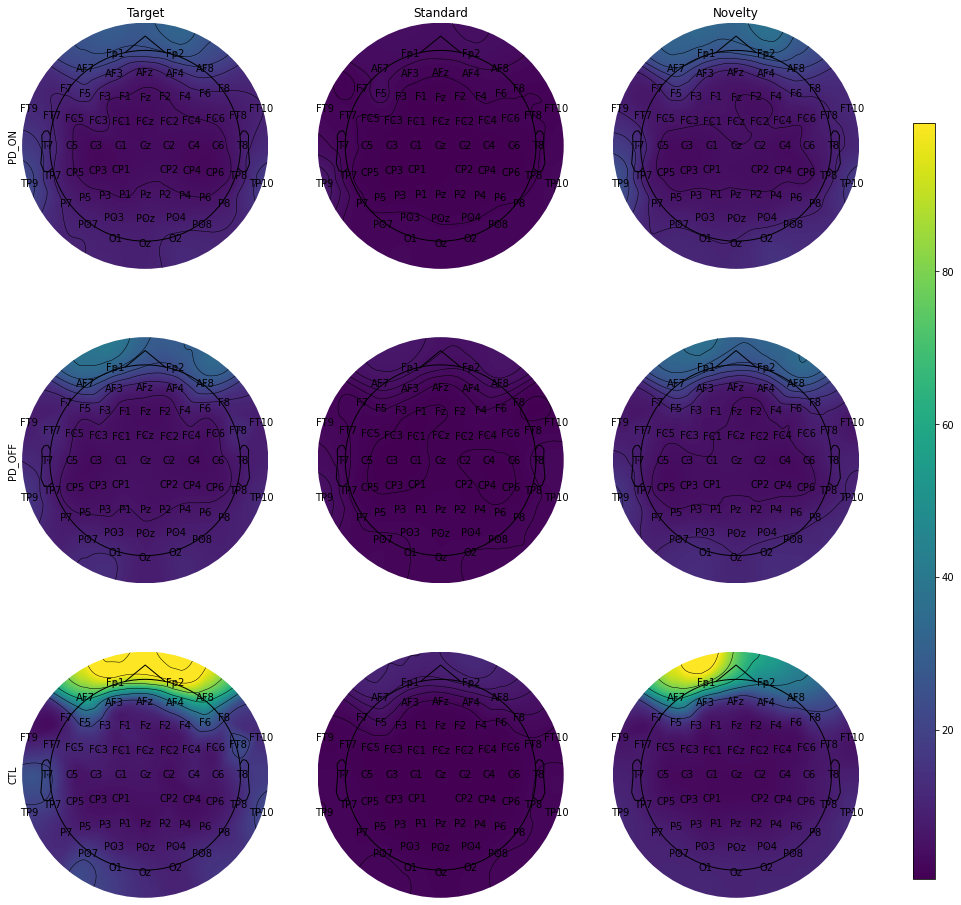

In [8]:



Path_to_load_ERP_collection = f'..\data\PAC_electordes_{start_time}_{end_time}_pair_fre_{High_fre}_{Low_fre}_nb_{nobaseline}.npy'
PAC_on_electrodes = np.load(Path_to_load_ERP_collection)

vmax = PAC_on_electrodes.max()
vmin = PAC_on_electrodes.min()  

fig, axs = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(15, 15))

mne_info = mne.create_info(ch_names=channels_name, sfreq=500., ch_types='eeg')

montage = mne.channels.read_custom_montage('Standard-10-20-Cap81.locs')

for i, j in itertools.product(range(3), range(3)):
#     data = mvls[i, :, j, :].mean(axis=0).reshape((-1, 1))
    temp = np.expand_dims(PAC_on_electrodes[i,j,:],axis=1)
    PAC_grand_mean = mne.EvokedArray(temp,mne_info)
    PAC_grand_mean.set_montage(montage)
    im, cm = mne.viz.plot_topomap(PAC_grand_mean.data[:,0], 
                                  PAC_grand_mean.info, axes=axs[i, j], show=False,
                                  names=channels_name, show_names=True, 
                                  vmin=vmin, vmax=vmax,res=200,cmap= 'viridis',fontsize='medium')

for i in range(3):
        axs[i, 0].set_ylabel(groups[i])
        axs[0, i].set_title(event_types[i])

        axs[-1, i].xaxis.set_visible(True)
        axs[i, 0].yaxis.set_visible(True)
        

cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])
clb = fig.colorbar(im, cax=cbar_ax)
fname = f'PAC_grand_mean_dur_{start_time}_{end_time}_pair_fre_{High_fre}_{Low_fre}_nb_{nobaseline}.png' 
       
if start_time == -200 and end_time==1000:
        Path_dir = f'D:\Mastersharif\MasterProject\data\parkinsons-oddball\\results\\topography_figures\PAC-total-grand-mean-high-low_fre-{High_fre}-{Low_fre}'
else:
        Path_dir = f'D:\Mastersharif\MasterProject\data\parkinsons-oddball\\results\\topography_figures\PAC-time_window-grand-mean-high-low_fre-{High_fre}-{Low_fre}'
       
if not os.path.isdir(Path_dir):
        os.mkdir(Path_dir)

file_path = os.path.join(Path_dir,fname)


plt.savefig(file_path)




            


        

## PAC time series calculation

In [44]:
 # Group name, stimulus type, channel num



# function optimized to run on gpu 
@jit
def PAC_caluculation(High_fre,Low_fre,dur,Fs):
    # dur = number of samples in a duration
    num_PAC_time_series = int(1200/((1000/Fs)*dur))
    PAC_on_electrodes_time_series = np.zeros([3,3,63,25,num_PAC_time_series])
    for i in np.arange(3):
        for j in np.arange(3):
            for ch in np.arange(63):
                for t in np.arange(num_PAC_time_series):
                    for sub in np.arange(25): 
                        PAC_on_electrodes_time_series[i,j,ch,sub,t] = pac.tfMVL(ERP_collection[i,sub,j,ch,t*dur:(t+1)*dur+1],high_freq=[High_fre,High_fre],low_freq=[Low_fre,Low_fre],Fs=500)  
    return PAC_on_electrodes_time_series

if __name__=="__main__":
    duration = 200
    Fs = 500
    num_sample_duration = int(200/(1000/Fs))
    PAC_electrodes_time_series = PAC_caluculation(High_fre,Low_fre,num_sample_duration,Fs)
    np.save(f'..\data\PAC_time_series_pair_fre_{High_fre}_{Low_fre}_nb_{nobaseline}',PAC_electrodes_time_series)                

C:\Users\Mohammad\AppData\Local\Temp/ipykernel_18652/3311135514.py:6: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "PAC_caluculation" failed type inference due to: No implementation of function Function(<built-in function zeros>) found for signature:
 
 >>> zeros(list(int64)<iv=None>)
 
There are 2 candidate implementations:
      - Of which 2 did not match due to:
      Overload of function 'zeros': File: numba\core\typing\npydecl.py: Line 511.
        With argument(s): '(list(int64)<iv=None>)':
       No match.

During: resolving callee type: Function(<built-in function zeros>)
During: typing of call at C:\Users\Mohammad\AppData\Local\Temp/ipykernel_18652/3311135514.py (10)


File "C:\Users\Mohammad\AppData\Local\Temp\ipykernel_18652\3311135514.py", line 10:
<source missing, REPL/exec in use?>

  @jit
C:\Users\Mohammad\AppData\Local\Temp/ipykernel_18652/3311135514.py:6: NumbaWarning: 
Compilation is falling back to object mode WI

## Plot time PAC series 

### load time PAC series

In [45]:
ERP_collection.shape

(3, 25, 3, 63, 601)

In [24]:
## total matrix with shape 3 3 63 25 6
PAC_time_series = np.load(f'..\data\PAC_time_series_pair_fre_{High_fre}_{Low_fre}_nb_{nobaseline}.npy')
PAC_time_series.shape

(3, 3, 63, 25, 6)

### Applying grand mean of PAC time series

In [25]:
PAC_time_series_gm = np.mean(PAC_time_series,axis=3)
PAC_time_series_gm.shape



(3, 3, 63, 6)

### Plot Target PAC sequences

In [5]:

Path_dir = f'D:\Mastersharif\MasterProject\data\parkinsons-oddball\\results\\PAC_vector\\pictures\\{High_fre}_{Low_fre}\\on_{event_types[0]}'
if not os.path.isdir:
    os.mkdir(Path_dir)

   

group_type = ['PD ON','PD OFF','CTL']

for ch,ch_name in enumerate(channels_name):
    fig, ax = plt.subplots(3,1,sharex=True,figsize=(15, 10))
    for i in np.arange(3):
        m,n,baseline = ax[i].stem(PAC_time_series_gm[i,0,ch,:])
        baseline.set_linewidth(0)
        ax[i].set_ylabel(group_type[i])
        ax[i].set_ylim([0,110])
    ax[2].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    ax[0].set_title(f'PAC_time_series pair Frequency ({High_fre},{Low_fre}) {ch_name} stimulus {event_types[0]}')
    ax[2].set_xlabel('Time windows (ms,ms)')
    plt.savefig(os.path.join(Path_dir,f'{ch_name}'))
    



NameError: name 'channels_name' is not defined

# Plot time PAC series for selected channel on the same plot


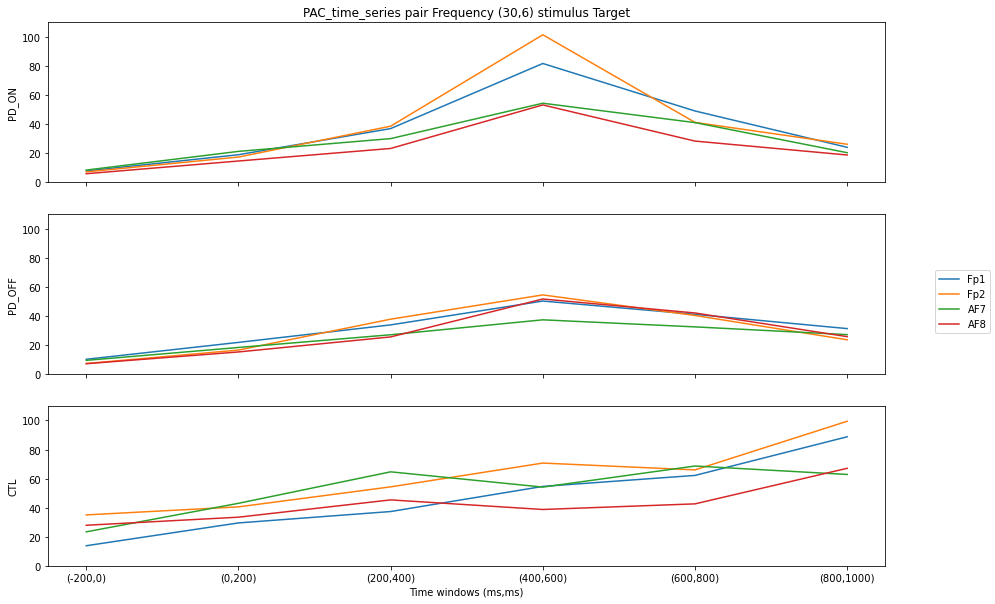

In [26]:
Path_dir = f'D:\Mastersharif\MasterProject\data\parkinsons-oddball\\results\\PAC_vector\\pictures\\{High_fre}_{Low_fre}\\on_{event_types[0]}'
select_channels = {'AF7','AF8','Fp1','Fp2'}

colors = ['r','g','b','orange']

NUM_COLORS = 4

cm = plt.get_cmap('viridis')



fig, ax = plt.subplots(3,1,sharex=True,figsize=(15, 10))

for i in np.arange(3):
    for c,ch_name in enumerate(select_channels):
        ch = channels_name.index(ch_name)
        ax[i].plot(PAC_time_series_gm[i,0,ch,:])
        # baseline.set_linewidth(0)
        ax[i].set_ylabel(groups[i])
        ax[i].set_ylim([0,110])   
ax[2].xaxis.set_major_formatter(plt.FuncFormatter(format_func))
ax[0].set_title(f'PAC_time_series pair Frequency ({High_fre},{Low_fre}) stimulus {event_types[0]}')
ax[2].set_xlabel('Time windows (ms,ms)')
fig.legend(select_channels,loc='center right')
plt.savefig(os.path.join(Path_dir,'selected_channels'))

'D:\\Mastersharif\\MasterProject\\data\\parkinsons-oddball\\results\\topography_figures\\PAC-time_window-grand-mean-high-low_fre-30-6'